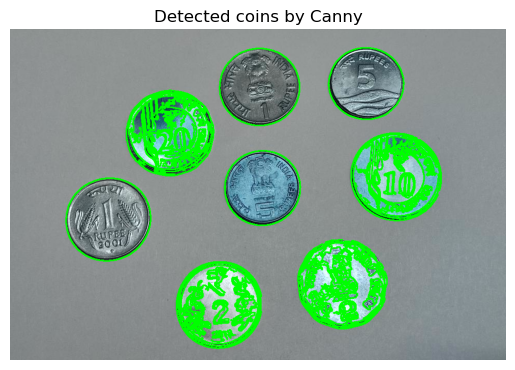

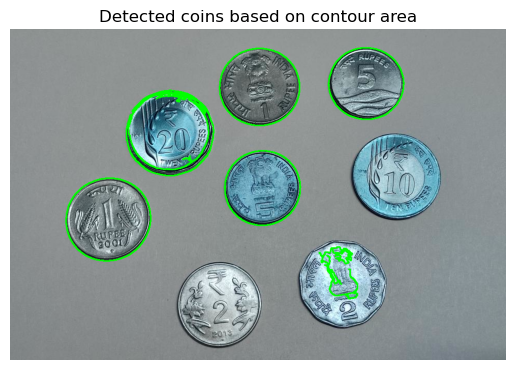

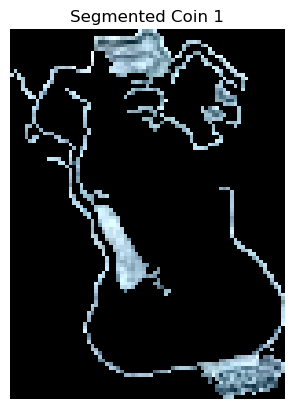

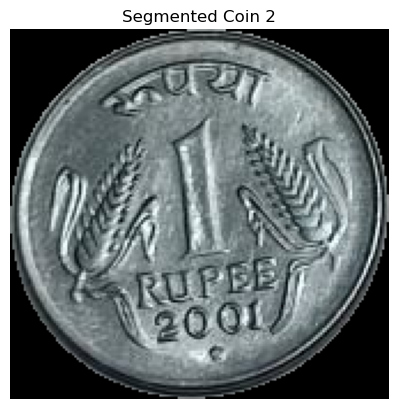

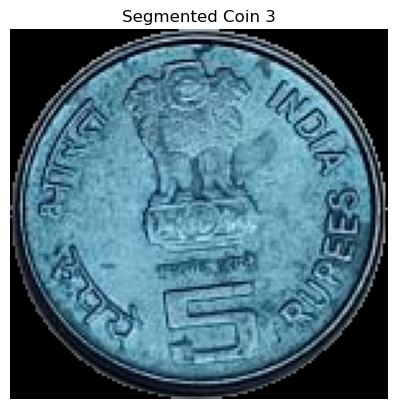

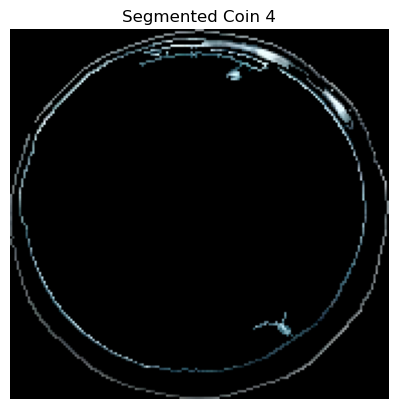

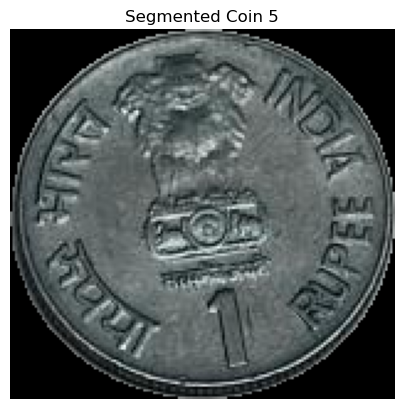

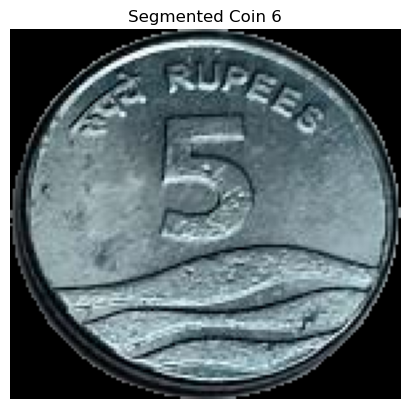

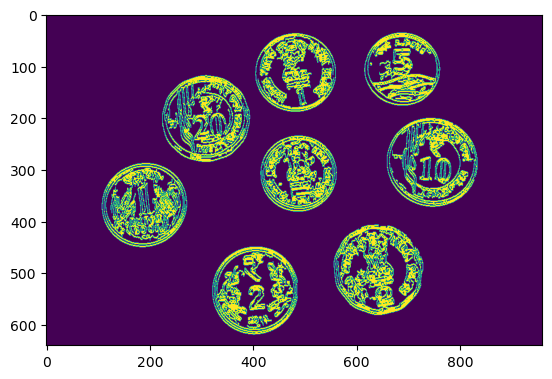

Number of coins in the image:  8


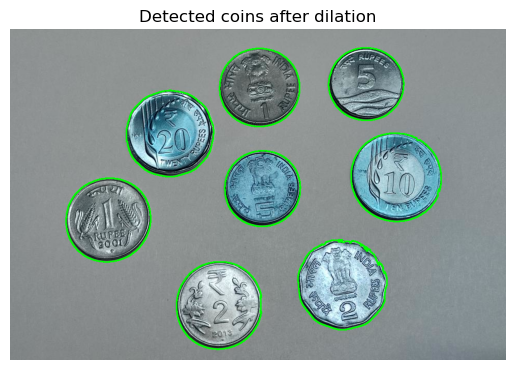

In [119]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#PART1 -- Task a: Detect coins using edge detection.
#--------------------
image = cv2.imread('coins.jpg')  

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (15,15), 1)

edges = cv2.Canny(blurred, 30, 150)

output_image = image.copy()

contours1, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(output_image, contours1, -1, (0, 255, 0), 2)
plt.imshow(output_image)
plt.title('Detected coins by Canny')
plt.axis('off')
plt.show()

#-----------------------------------------------------------------------------------------------------
#Task b: Region based segmentation of coins
#-----------------------------------------------------------------------------------------------------

min_coin_area =350  # Minimum area to be considered a coin
valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_coin_area]

output_image = image.copy()
cv2.drawContours(output_image, valid_contours, -1, (0, 255, 0), 2)  

plt.imshow(output_image)
plt.title('Detected coins based on contour area')
plt.axis('off')
plt.show()


for i, contour in enumerate(valid_contours):
    # mask for the current coin
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [contour], -1, 255, -1)

    coin = cv2.bitwise_and(image, image, mask=mask)

    # bounding box
    x, y, w, h = cv2.boundingRect(contour)
    cropped_coin = coin[y:y+h, x:x+w]

    plt.imshow(cropped_coin)
    plt.title(f'Segmented Coin {i+1}')
    plt.savefig('./imgs/Segmented Coin'+str({i+1}, )
    plt.axis('off')
    plt.show()

#------------------------------------------------------------------------------------
#Task c: Detect Number of coins
#------------------------------------------------------------------------------------

#Here dilation of edges adds pixels to the edges thereby reducing the countours
#dilation merges the nearby edges, fills the small gaps 

dilated = cv2.dilate(edges, (1,1), iterations = 2)
plt.imshow(dilated)
plt.show()

output_image = image.copy()
contours2, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(output_image, contours2, -1, (0, 255, 0), 2)  

print("Number of coins in the image: " ,len(contours2))

plt.imshow(output_image)
plt.title('Detected coins after dilation')
plt.axis('off')
plt.show()

In [134]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to stitch two images
def stitch_images(img1, img2):
    # Detect key points and descriptors using SIFT
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    # Match key points using FLANN based matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Filter matches using the Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:  # Lowe's ratio test
            good_matches.append(m)

    # Compute homography using RANSAC
    if len(good_matches) > 10:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    else:
        raise Exception("Not enough matches found to compute homography.")

    # Warp the second image using the homography matrix
    height, width, _ = img1.shape
    warped_image = cv2.warpPerspective(img2, H, (width + img2.shape[1], height))

    # Blend the images into a panorama
    warped_image[0:height, 0:width] = img1

    return warped_image

# Step 1: Load the overlapping images
image1 = cv2.imread('image1.jpeg')  # Replace with your image paths
image2 = cv2.imread('image2.jpeg')  # Replace with your image paths
image3 = cv2.imread('image3.jpeg')  # Replace with your image paths

# Convert images to RGB for visualization
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)

# Step 2: Stitch the first two images
temp_panorama = stitch_images(image1, image2)

# Step 3: Stitch the third image with the temporary panorama
final_panorama = stitch_images(temp_panorama, image3)

# Step 4: Display the final panorama
plt.imshow(final_panorama)
plt.title('Stitched Panorama (3 Images)')
plt.axis('off')
plt.show()

Exception: Not enough matches found to compute homography.

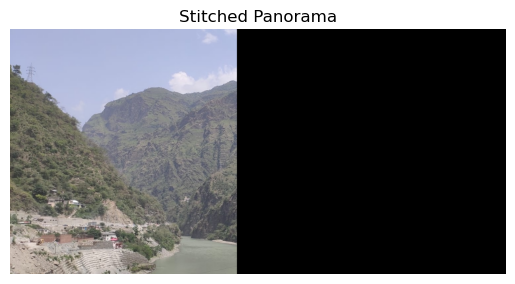

In [131]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the overlapping images
image1 = cv2.imread('image1.jpeg')  # Replace with your image paths
image2 = cv2.imread('image2.jpeg')  # Replace with your image paths

# Convert images to RGB for visualization
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Step 2: Detect key points and descriptors using SIFT
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Step 3: Match key points using FLANN based matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Step 4: Filter matches using the Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:  # Lowe's ratio test
        good_matches.append(m)

# Step 5: Compute homography using RANSAC
if len(good_matches) > 10:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
else:
    raise Exception("Not enough matches found to compute homography.")

# Step 6: Warp the second image using the homography matrix
height, width, _ = image1.shape
warped_image = cv2.warpPerspective(image2, H, (width + image2.shape[1], height))

# Step 7: Blend the images into a panorama
warped_image[0:height, 0:width] = image1

# Step 8: Display the final panorama
plt.imshow(warped_image)
plt.title('Stitched Panorama')
plt.axis('off')
plt.show()

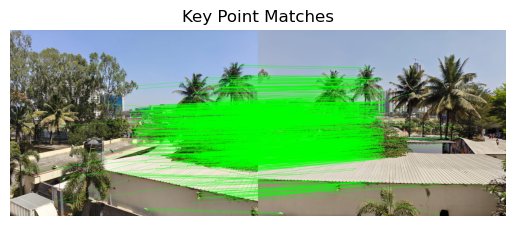

[[ 2.35119622e+00  6.25706424e-03 -1.81914159e+03]
 [ 4.78122262e-01  1.95304724e+00 -5.91695331e+02]
 [ 8.56164361e-04  1.60012956e-06  1.00000000e+00]]


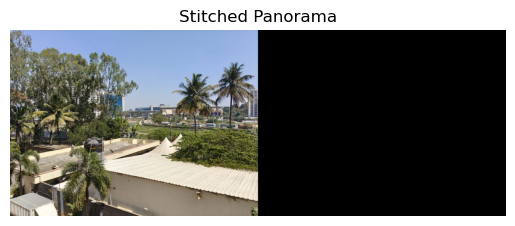

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the overlapping images
image1 = cv2.imread('image1.jpeg')  # Replace with your image paths
image2 = cv2.imread('image2.jpeg')  # Replace with your image paths

# Convert images to RGB for visualization
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Step 2: Detect key points and descriptors using SIFT
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Step 3: Match key points using FLANN based matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Step 4: Filter matches using the Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:  # Lowe's ratio test
        good_matches.append(m)

# Step 5: Draw matches
matched_image = cv2.drawMatches(
    image1, keypoints1,  # First image and its key points
    image2, keypoints2,  # Second image and its key points
    good_matches,        # List of good matches
    None,                # Optional output image
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,  # Don't draw single points
    matchColor=(0, 255, 0),  # Color for matches (green)
    singlePointColor=(255, 0, 0),  # Color for single points (blue)
)

# Step 6: Display the matches
plt.imshow(matched_image)
plt.title('Key Point Matches')
plt.axis('off')
plt.show()

# Step 7: Compute homography using RANSAC
if len(good_matches) > 10:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
else:
    raise Exception("Not enough matches found to compute homography.")
print(H)
# Step 8: Warp the second image using the homography matrix
height, width, _ = image1.shape
warped_image = cv2.warpPerspective(image2, H, (width + image2.shape[1], height))

# Step 9: Blend the images into a panorama
warped_image[0:height, 0:width] = image1

# Step 10: Display the final panorama
plt.imshow(warped_image)
plt.title('Stitched Panorama')
plt.axis('off')
plt.show()

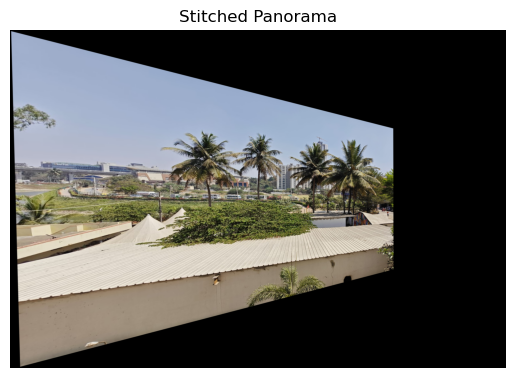

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
image1 = cv2.imread('image1.jpeg')  # Replace with your image paths
image2 = cv2.imread('image2.jpeg')  # Replace with your image paths

# Convert images to RGB for visualization
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Detect key points and descriptors using SIFT
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Match key points using FLANN-based matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Filter matches using Lowe's ratio test
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

# Compute homography
if len(good_matches) > 10:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
else:
    raise Exception("Not enough matches found to compute homography.")

# Get the dimensions of both images
h1, w1, _ = image1.shape
h2, w2, _ = image2.shape

# Find the perspective transformation of image2's corners
corners = np.array([
    [0, 0],
    [0, h2],
    [w2, 0],
    [w2, h2]
], dtype=np.float32).reshape(-1, 1, 2)

transformed_corners = cv2.perspectiveTransform(corners, H)

# Compute the dimensions of the new canvas
all_corners = np.concatenate((corners, transformed_corners), axis=0)
[x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 10)
[x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 10)

# Compute translation matrix to shift the images
translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float32)
# Warp image2 onto the larger canvas
result = cv2.warpPerspective(image2, translation @ H, (x_max - x_min, y_max - y_min))

# Overlay image1 onto the panorama
# result[-y_min:h1 - y_min, -x_min:w1 - x_min] = image1

# Convert to uint8 to avoid visualization issues
# result = np.clip(result, 0, 255).astype(np.uint8)

# Display the final panorama
plt.imshow(result)
plt.title('Stitched Panorama')
plt.axis('off')
plt.show()


Your Panorama is ready!!!


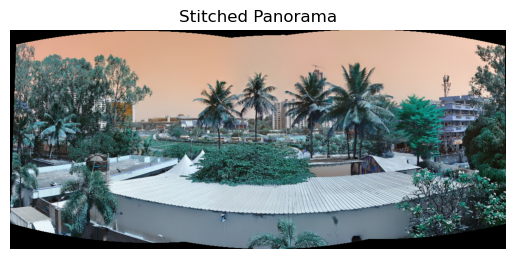

Panorama Dimensions: 1041x460
Number of Channels: 3
Data Type: uint8
Total Pixels: 1436580
Mean Pixel Intensity: [114.41132272 121.0965397  119.28589776]
Standard Deviation: [78.05957116 64.80911949 63.27024864]
Panorama saved as 'stitched_panorama.jpg'


In [7]:
import cv2 
import matplotlib.pyplot as plt
image_paths=['image1.jpeg','image2.jpeg','image3.jpeg'] 
# initialized a list of images 
imgs = [] 

for i in range(len(image_paths)): 
	imgs.append(cv2.imread(image_paths[i])) 
	imgs[i]=cv2.resize(imgs[i],(0,0),fx=0.4,fy=0.4) 
	# this is optional if your input images isn't too large 
	# you don't need to scale down the image 
	# in my case the input images are of dimensions 3000x1200 
	# and due to this the resultant image won't fit the screen 
	# scaling down the images 
# showing the original pictures 
# cv2.imshow('1',imgs[0]) 
# cv2.imshow('2',imgs[1]) 
# cv2.imshow('3',imgs[2]) 

stitchy=cv2.Stitcher.create() 
(dummy,output)=stitchy.stitch(imgs) 

if dummy != cv2.STITCHER_OK: 
# checking if the stitching procedure is successful 
# .stitch() function returns a true value if stitching is 
# done successfully 
	print("stitching ain't successful") 
else: 
	print('Your Panorama is ready!!!') 

# # final output 
# cv2.imshow('final result',output) 

# cv2.waitKey(0)
plt.imshow(output)
plt.title('Stitched Panorama')
plt.axis('off')
plt.show()


if output is not None:
    height, width, channels = output.shape
    print(f"Panorama Dimensions: {width}x{height}")
    print(f"Number of Channels: {channels}")

if output is not None:
    print(f"Data Type: {output.dtype}")
    print(f"Total Pixels: {output.size}")  # Total number of pixels (width × height × channels)

if output is not None:
    mean, stddev = cv2.meanStdDev(output)
    print(f"Mean Pixel Intensity: {mean.flatten()}")
    print(f"Standard Deviation: {stddev.flatten()}")

if output is not None and cv2.countNonZero(cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)) == 0:
    print("Warning: The stitched image is completely black (stitching failed).")

if output is not None:
    cv2.imwrite('stitched_panorama.jpg', output)
    print("Panorama saved as 'stitched_panorama.jpg'")


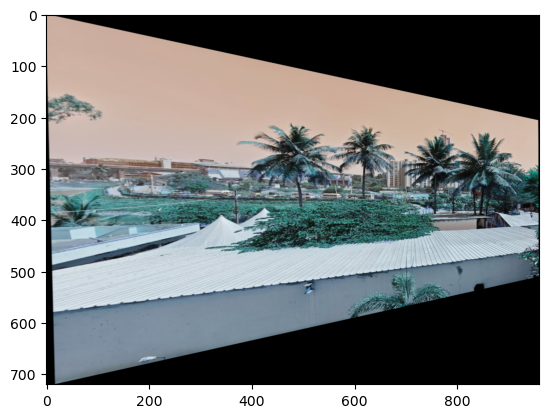

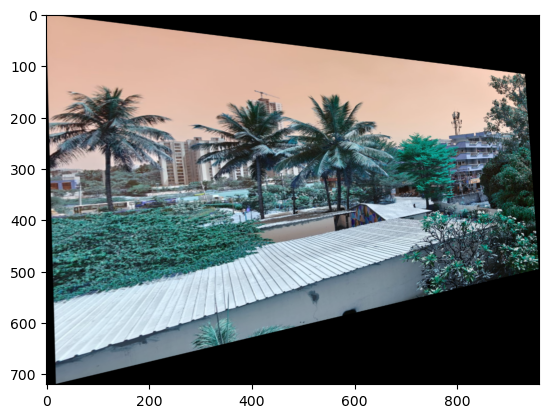

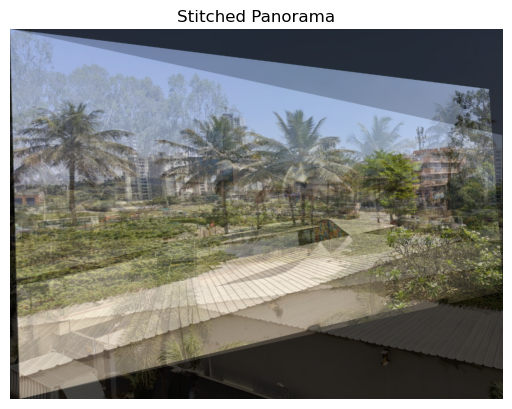

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
image_paths = ['image1.jpeg', 'image2.jpeg', 'image3.jpeg']
imgs = [cv2.imread(path) for path in image_paths]

# Resize images (optional)
imgs = [cv2.resize(img, (0, 0), fx=0.6, fy=0.6) for img in imgs]

# Convert images to grayscale
gray_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in imgs]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors with SIFT
keypoints = []
descriptors = []
for gray in gray_imgs:
    kp, des = sift.detectAndCompute(gray, None)
    keypoints.append(kp)
    descriptors.append(des)

# Match descriptors between images
bf = cv2.BFMatcher()
matches = []
for i in range(len(descriptors) - 1):
    matches.append(bf.knnMatch(descriptors[i], descriptors[i + 1], k=2))

# Apply ratio test to find good matches
good_matches = []
for i, match in enumerate(matches):
    good = []
    for m, n in match:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    good_matches.append(good)

# Compute homography and warp images
homographies = []
for i in range(len(good_matches)):
    src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in good_matches[i]]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints[i + 1][m.trainIdx].pt for m in good_matches[i]]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    homographies.append(H)

# Warp images using the homography
warped_imgs = [imgs[0]]
for i in range(1, len(imgs)):
    # Calculate the size of the output panorama
    h1, w1 = imgs[i - 1].shape[:2]
    h2, w2 = imgs[i].shape[:2]
    pts = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, homographies[i - 1])
    [xmin, ymin] = np.int32(dst.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(dst.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    H_translation = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]], dtype=np.float32)  # Ensure it's float32

    # Warp the image
    warped = cv2.warpPerspective(imgs[i], H_translation.dot(homographies[i - 1]), (xmax - xmin, ymax - ymin))
    warped_imgs.append(warped)

    # Translate the first image to align with the warped image
    if i == 1:
        imgs[0] = cv2.warpPerspective(imgs[0], H_translation.astype(np.float32), (xmax - xmin, ymax - ymin))  # Ensure float32

# Blend images
result = warped_imgs[0]
for i in range(1, len(warped_imgs)):
    # Ensure both images have the same dimensions
    h, w = result.shape[:2]
    warped_img_resized = cv2.resize(warped_imgs[i], (w, h))  # Resize warped_imgs[i] to match result

    # Create a mask to blend only the overlapping regions
    mask1 = cv2.cvtColor(cv2.threshold(cv2.cvtColor(result, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)[1], cv2.COLOR_GRAY2BGR)
    mask2 = cv2.cvtColor(cv2.threshold(cv2.cvtColor(warped_img_resized, cv2.COLOR_BGR2GRAY), 1, 255, cv2.THRESH_BINARY)[1], cv2.COLOR_GRAY2BGR)
    plt.imshow(warped_img_resized)
    plt.show()
    # Blend the images
    result = cv2.addWeighted(result, 0.5, warped_img_resized, 0.5, 0)
    
# Display the result
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Stitched Panorama')
plt.axis('off')
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
image_paths = ['image1.jpeg', 'image2.jpeg', 'image3.jpeg']
imgs = [cv2.imread(path) for path in image_paths]

# Resize images (optional)
imgs = [cv2.resize(img, (0, 0), fx=0.4, fy=0.4) for img in imgs]

# Convert images to grayscale
gray_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in imgs]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors with SIFT
keypoints = []
descriptors = []
for gray in gray_imgs:
    kp, des = sift.detectAndCompute(gray, None)
    keypoints.append(kp)
    descriptors.append(des)

# Match descriptors between images
bf = cv2.BFMatcher()
matches = []
for i in range(len(descriptors) - 1):
    matches.append(bf.knnMatch(descriptors[i], descriptors[i + 1], k=2))

# Apply ratio test to find good matches
good_matches = []
for i, match in enumerate(matches):
    good = []
    for m, n in match:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    good_matches.append(good)

# Compute homography transformations to align images
homographies = [np.eye(3)]  # Identity matrix for the first image

for i in range(len(good_matches)):
    src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in good_matches[i]]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints[i + 1][m.trainIdx].pt for m in good_matches[i]]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Compute cumulative homography
    homographies.append(homographies[-1] @ H)

# Compute the global canvas size for warping
corners = []
for i, img in enumerate(imgs):
    h, w = img.shape[:2]
    pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, homographies[i])
    corners.append(dst)

corners = np.vstack(corners)
[xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)

# Compute translation homography to shift everything into the visible area
t = [-xmin, -ymin]
H_translation = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]], dtype=np.float32)

# Warp images into the common plane
panorama = np.zeros((ymax - ymin, xmax - xmin, 3), dtype=np.uint8)

for i, img in enumerate(imgs):
    warped_img = cv2.warpPerspective(img, H_translation @ homographies[i], (xmax - xmin, ymax - ymin))
    
    # Create a mask to blend images properly
    mask = (warped_img > 0).astype(np.uint8) * 255  # Non-black areas
    panorama = cv2.seamlessClone(warped_img, panorama, mask, (xmax//2, ymax//2), cv2.NORMAL_CLONE)

# Display the result
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title('Stitched Panorama')
plt.axis('off')
plt.show()


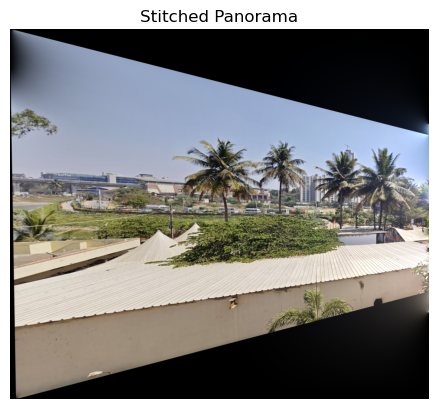

Panorama saved as 'stitched_panorama.jpg'


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
image_paths = ['image1.jpeg', 'image2.jpeg', 'image3.jpeg']
imgs = [cv2.imread(path) for path in image_paths]

# Convert images to grayscale
gray_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in imgs]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors with SIFT
keypoints, descriptors = [], []
for gray in gray_imgs:
    kp, des = sift.detectAndCompute(gray, None)
    keypoints.append(kp)
    descriptors.append(des)

# Match descriptors between images
bf = cv2.BFMatcher()
matches = [bf.knnMatch(descriptors[i], descriptors[i + 1], k=2) for i in range(len(descriptors) - 1)]

# Apply Lowe’s ratio test
good_matches = [[m for m, n in match if m.distance < 0.75 * n.distance] for match in matches]

# Compute homographies
homographies = []
for i in range(len(good_matches)):
    src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in good_matches[i]]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints[i + 1][m.trainIdx].pt for m in good_matches[i]]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    homographies.append(H)

# Compute panorama size
h1, w1 = imgs[0].shape[:2]
h2, w2 = imgs[1].shape[:2]

# Warp second image based on the first image
pts = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, homographies[0])
[xmin, ymin] = np.int32(dst.min(axis=0).ravel() - 0.5)
[xmax, ymax] = np.int32(dst.max(axis=0).ravel() + 0.5)

# Translation matrix to move into positive coordinates
translation_matrix = np.array([[1, 0, -xmin], [0, 1, -ymin], [0, 0, 1]], dtype=np.float32)

# Warp images
warped_img1 = cv2.warpPerspective(imgs[0], translation_matrix, (xmax - xmin, ymax - ymin))
warped_img2 = cv2.warpPerspective(imgs[1], translation_matrix.dot(homographies[0]), (xmax - xmin, ymax - ymin))

# Resize both images to the same size before blending
h_min = min(warped_img1.shape[0], warped_img2.shape[0])
w_min = min(warped_img1.shape[1], warped_img2.shape[1])

warped_img1 = cv2.resize(warped_img1, (w_min, h_min))
warped_img2 = cv2.resize(warped_img2, (w_min, h_min))

# Create a mask for blending
mask = np.ones_like(warped_img1, dtype=np.uint8) * 255  # White mask
center = (w_min // 2, h_min // 2)  # Center of the stitched image

# Perform seamless blending
blended_result = cv2.seamlessClone(warped_img2, warped_img1, mask[:, :, 0], center, cv2.NORMAL_CLONE)

# Display result
plt.imshow(cv2.cvtColor(blended_result, cv2.COLOR_BGR2RGB))
plt.title('Stitched Panorama')
plt.axis('off')
plt.show()

# Save result
cv2.imwrite('stitched_panorama.jpg', blended_result)
print("Panorama saved as 'stitched_panorama.jpg'")


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
image_paths = ['image1.jpeg', 'image2.jpeg', 'image3.jpeg']
imgs = [cv2.imread(path) for path in image_paths]

In [2]:
for i in imgs:
    print(i.shape)

(1200, 1600, 3)
(1200, 1600, 3)
(1200, 1600, 3)
